In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [251]:
df = pd.read_csv('results-survey080419.csv')
df = df.drop(df.columns[[range(0,6)]], axis=1)
df.rename(columns={df.columns[0]: 'Country', df.columns[1]: 'Business Category'\
                   , df.columns[2]: 'Business Category [Business Category - Other]'\
                   , df.columns[12]: 'Campaign Run'}, inplace=True)
df['Country'].replace(np.nan, "Other", inplace=True)
df.dropna(subset=['Campaign Run'], inplace=True)
print("First Cleaning\nTotal Number of responses: {}".format(len(df)))
print("Number of countries that responded: {}".format(len(df['Country'].value_counts())-1))#minus 1 of 'Other'
print("Responses with no country specified: {}\n".format(len(df[df['Country'] == "Other"])))

#Dropping all responses with less than 60% completion rate
df = df.dropna(thresh=df.shape[1]-70) #drop rows where NaN values constituate up to 102 of the total entries
print("Second Cleaning\nTotal Number of responses: {}".format(len(df)))
print("Number of countries that responded: {}".format(len(df['Country'].value_counts())-1))#minus 1 of 'Other'
print("Responses with no country specified: {}".format(len(df[df['Country'] == "Other"])))

#Businesses that run measurement
runm = len(df[['Business Category', 'Campaign Run']][df['Campaign Run']=="Yes"])
runp = round(runm/len(df)*100, 2)
print("\nTotal number of businesses than run some measurement: {} or {}% of all responses".format(runm, runp))

#Grouping businesses
def group_business(busdf, colname):
    if 'Business Category' != colname:
        
        busdf.loc['Internet Service Provider (ISP)'] += busdf.loc['Telecom (Mobile) Operator'] #merging to ISP
        busdf.loc['Academic Institution'] += busdf.loc['Academic network (NRENs)'] #merging to academic institutions

        grouped = busdf.loc['Community Network'] + busdf.loc['Enterprise Network'] \
        + busdf.loc['ccTLD/DNS Operator'] #Adding all to 'Other'. No valid response from Cable Operator,
        busdf.loc['Other'] += grouped     # Wireless Network, Data Centre
        #Removing categories after merging to main groups
        busdf.drop(['Academic network (NRENs)', 'Telecom (Mobile) Operator', 'Enterprise Network',
                'Community Network', 'ccTLD/DNS Operator'], inplace=True)
    else:
        busdf = busdf[colname].value_counts()
        ispsum = busdf.loc['Telecom (Mobile) Operator'] + busdf.loc['Wireless network'] #merging to ISP
        busdf.loc['Internet Service Provider (ISP)'] += ispsum #Adding sum values to ISP total
        busdf.loc['Academic Institution'] += busdf.loc['Academic network (NRENs)'] #merging to academic institutions

        grouped = busdf.loc['Community Network'] + busdf.loc['Enterprise Network']\
        + busdf.loc['ccTLD/DNS Operator'] + busdf.loc['Datacentre']    #Adding all to 'Other'. No valid response from Cable Operator
        busdf.loc['Other'] += grouped
    #Removing categories after merging to main groups
        busdf.drop(['Academic network (NRENs)', 'Telecom (Mobile) Operator', 'Wireless network', 
                'Enterprise Network', 'Community Network', 'ccTLD/DNS Operator', 'Datacentre'],
               inplace=True)
    return busdf

First Cleaning
Total Number of responses: 156
Number of countries that responded: 35
Responses with no country specified: 9

Second Cleaning
Total Number of responses: 119
Number of countries that responded: 34
Responses with no country specified: 4

Total number of businesses than run some measurement: 30 or 25.21% of all responses


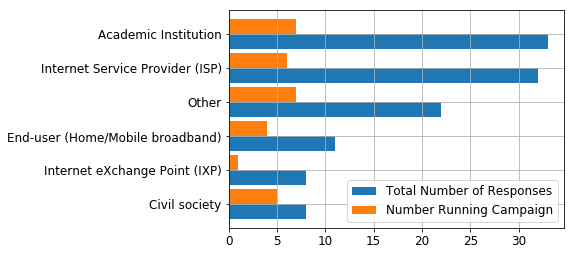

In [254]:
#Whether a business category has run measurements or not
def measurement_campaign():
    countries = group_business(df, 'Business Category')
    runcamp = df[['Business Category', 'Campaign Run']][df['Campaign Run']=="Yes"]
    runcamp = runcamp.groupby('Business Category').agg({'Campaign Run': 'count'})
    groupBus = group_business(runcamp, 'Campaign Run')
    
    final = pd.concat([countries, groupBus], axis=1, join='inner', sort=True)
    final.rename(columns={'Business Category': 'Total Number of Responses', 'Campaign Run':'Number Running Campaign'}, inplace=True)
    final = final.sort_values(by = ['Total Number of Responses'])
    ax = final.plot(kind='barh', legend=True, width=.9, grid=True)
    plt.show()
    return
measurement_campaign()

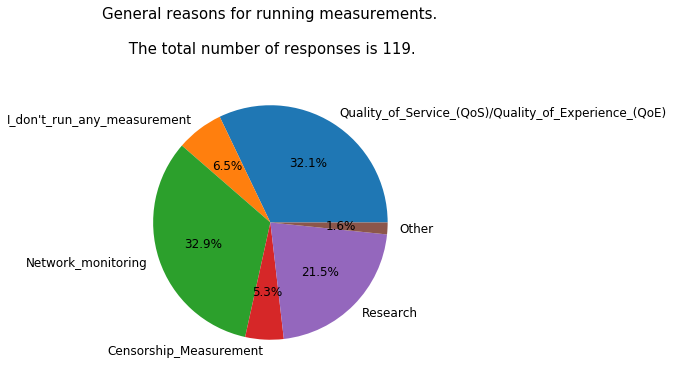

In [256]:
#General reasons for running measurement
def reasons_for_measurement():
    reasons =['Business Category [Business Category - Other]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Network_monitoring]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Quality_of_Service_(QoS)/Quality_of_Experience_(QoE)]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Research]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Censorship_Measurement]',
              "6._Please_state_your_main_purpose_for_running_network_measurements?_[I_don't_run_any_measurement]",
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Other]']
    df2 = df[reasons]
    freq = []
    purpose = []
    for col in df2.columns:
        if col == "6._Please_state_your_main_purpose_for_running_network_measurements?_[Other]":
            new_purpose = tuple(df2[col].dropna().unique())
            for purp in new_purpose:
                freq.append(1)
                purpose.append(purp)
        else:
            value = len(df2[df2[col]=="Yes"])
            freq.append(value)
            ntype = col.split('[')[1].split(']')[0]
            purpose.append(ntype)
    values = zip(purpose, freq)
    final = dict(set(values))
    #plot piechart by combining all entries with less than one percent of the total as others
    dsum = sum(final.values())
    dthresh = dsum * 0.01
    includedict = {}
    excludedict = {}
    
    for k, v in final.items():
        if v >= dthresh:
            includedict.update({k:v})
        else:
            excludedict.update({k:v})
            others = sum(excludedict.values())
    
    total_resp = len(df2.index)
    includedict.update({'Other':others})
    y = includedict.values()
    label = includedict.keys()
    plt.pie([float(v) for v in y], labels=[k for k in label], autopct='%1.1f%%')
    plt.axis('equal')
    plt.rcParams['font.size'] = 12
    plt.tight_layout()
    plt.title("General reasons for running measurements.\n\n The total number of responses is {}.\n\n".
              format(total_resp), fontsize=15)
    plt.show()
    
    return 
reasons_for_measurement()


The different reasons why the businesses run measurements.




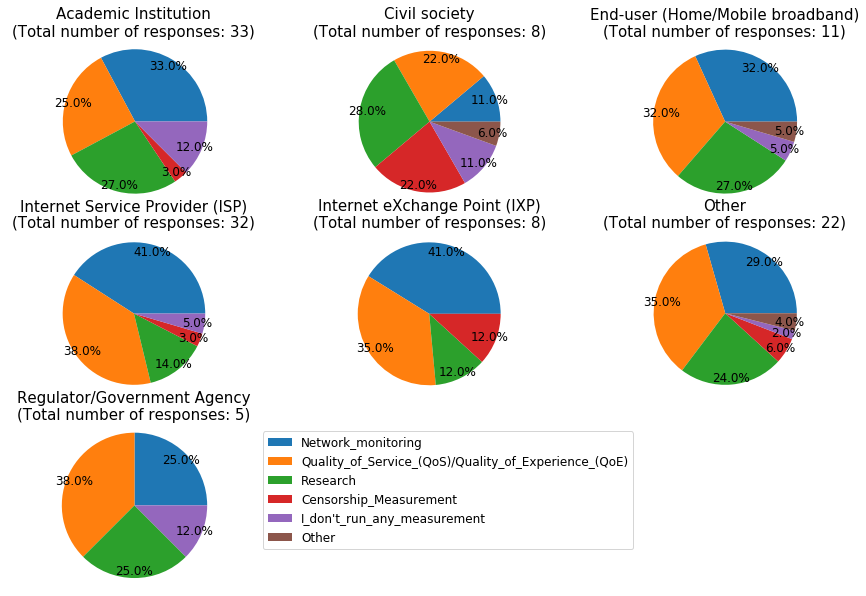

In [257]:
#Specific reasons why business categories are running measurements
def specific_reasons():
    
    columns =['Business Category','6._Please_state_your_main_purpose_for_running_network_measurements?_[Network_monitoring]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Quality_of_Service_(QoS)/Quality_of_Experience_(QoE)]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Research]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Censorship_Measurement]',
              "6._Please_state_your_main_purpose_for_running_network_measurements?_[I_don't_run_any_measurement]",
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Other]']

    df2 = df[columns]
    df2.replace(('Yes', 'No','Academic network (NRENs)', 'Telecom (Mobile) Operator','Wireless network',
                'Enterprise Network','ccTLD/DNS Operator','Community Network','Datacentre', 'Cable Operator'),
                (1, 0, 'Academic Institution', 'Internet Service Provider (ISP)',
                 'Internet Service Provider (ISP)', 'Other', 'Other', 'Other', 'Other', 'Other'), inplace=True)
    #size of each category
    df2.set_index('Business Category', inplace=True)
    isp = len(df2.loc['Internet Service Provider (ISP)'])
    acad = len(df2.loc['Academic Institution'])
    ixp = len(df2.loc['Internet eXchange Point (IXP)'])
    civil = len(df2.loc['Civil society'])
    reg = len(df2.loc['Regulator/Government Agency'])
    end_user = len(df2.loc['End-user (Home/Mobile broadband)'])
    other = len(df2.loc['Other'])

    #Extract the required headings
    for col in df2.columns:
        name = col.split('[')[1].split(']')[0]
        df2.rename(columns={col:name}, inplace=True)
    
    df2['Other'] = df2['Other'].notnull().astype(int)
    df2.fillna(value={'Other':0}, inplace=True)
   
    df3 = df2.groupby(level=0, as_index=True).sum()

    
    fig = plt.figure(figsize=(15,10))
    
    print("\nThe different reasons why the businesses run measurements.\n\n")
    for i, (name, row) in enumerate(df3.iterrows()):
        ax = plt.subplot(3,3, i+1)
        column = "'" + name + "'"
        if name == 'Internet Service Provider (ISP)':
            title = row.name + "\n(Total number of responses: " + str(isp) + ")"
            ax.set_title(title, fontsize=15)
        elif name == 'Academic Institution':
            title = row.name + "\n(Total number of responses: " + str(acad) + ")"
            ax.set_title(title, fontsize=15)
        elif name == 'Internet eXchange Point (IXP)':
            title = row.name + "\n(Total number of responses: " + str(ixp) + ")"
            ax.set_title(title, fontsize=15)
        elif name == 'Civil society':
            title = row.name + "\n(Total number of responses: " + str(civil) + ")"
            ax.set_title(title, fontsize=15)
        elif name == 'Regulator/Government Agency':
            title = row.name + "\n(Total number of responses: " + str(reg) + ")"
            ax.set_title(title, fontsize=15)
        elif name == 'End-user (Home/Mobile broadband)':
            title = row.name + "\n(Total number of responses: " + str(end_user) + ")"
            ax.set_title(title, fontsize=15)
        else:
            title = row.name + "\n(Total number of responses: " + str(other) + ")"
            ax.set_title(title, fontsize=15)
        ax.set_aspect('equal')
        ax.pie(row, autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '', 
               pctdistance=0.9, labels=None)
        ax.axis('equal')#ensure that the pie is drawn as circle
    plt.legend(loc="best", labels=row.index, bbox_to_anchor=(1,1))
    plt.show()
    return 
specific_reasons()


The metrics of interest for the different businesses.




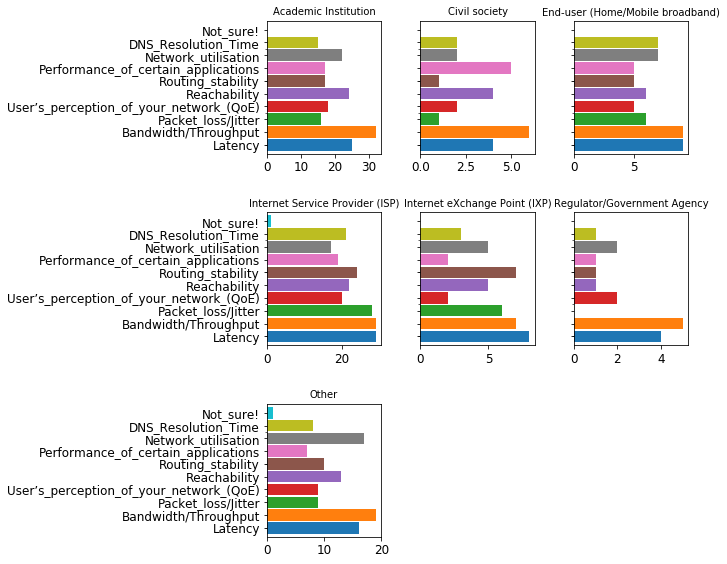

In [259]:
#The popular metrics
def metrics():
    metrics_list =['Business Category',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Latency]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Bandwidth/Throughput]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Packet_loss/Jitter]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[User’s_perception_of_your_network_(QoE)]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Reachability]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Routing_stability]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Performance_of_certain_applications_(Youtube,_Facebook,_etc)]]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Network_utilisation]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[DNS_Resolution_Time]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Not_sure!]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Other]',]
    
    df2 = df[metrics_list]
    df2.replace(('Yes', 'No','Academic network (NRENs)', 'Telecom (Mobile) Operator','Wireless network',
                'Enterprise Network','ccTLD/DNS Operator','Community Network','Datacentre', 'Cable Operator'),
                (1, 0, 'Academic Institution', 'Internet Service Provider (ISP)',
                 'Internet Service Provider (ISP)', 'Other', 'Other', 'Other', 'Other', 'Other'), inplace=True)
    #size of each category
    df2.set_index('Business Category', inplace=True)
    isp = len(df2.loc['Internet Service Provider (ISP)'])
    acad = len(df2.loc['Academic Institution'])
    ixp = len(df2.loc['Internet eXchange Point (IXP)'])
    civil = len(df2.loc['Civil society'])
    reg = len(df2.loc['Regulator/Government Agency'])
    end_user = len(df2.loc['End-user (Home/Mobile broadband)'])
    other = len(df2.loc['Other'])
    #df2.reset_index(inplace=True)
    
    #Extract the required headings
    for col in df2.columns:
        name = col.split('[')[1].split(']')[0]
        if name == "Performance_of_certain_applications_(Youtube,_Facebook,_etc)":
            name=name.split("(")[0][:-1]
        df2.rename(columns={col:name}, inplace=True)
    
    df2.drop(['Other'], axis=1, inplace=True)
    '''df2['Other'] = df2['Other'].notnull().astype(int)
    df2.fillna(value={'Other':0}, inplace=True)'''
   
    df3 = df2.groupby(level=0, as_index=True).sum()
    fig, axes = plt.subplots(3,3, sharex=False, sharey=True)

    print("\nThe metrics of interest for the different businesses.\n\n")
    df3.loc['Academic Institution'].plot.barh(width=.9, figsize=(15, 10), ax=axes[0, 0])
    axes[0, 0].set_title(df3.loc['Academic Institution'].name, size=10)
    axes[0, 0].set_xticks([0,10,20,30])
    
    df3.loc['Civil society'].plot.barh(width=.9, figsize=(15, 10), ax=axes[0, 1])
    axes[0, 1].set_title(df3.loc['Civil society'].name, size=10)
    
    df3.loc['End-user (Home/Mobile broadband)'].plot.barh(width=.9, figsize=(15, 10), ax=axes[0, 2])
    axes[0, 2].set_title(df3.loc['End-user (Home/Mobile broadband)'].name, size=10)
    
    df3.loc['Internet Service Provider (ISP)'].plot.barh(width=.9, figsize=(15, 10), ax=axes[1, 0])
    axes[1, 0].set_title("\n" + df3.loc['Internet Service Provider (ISP)'].name, size=10)
    
    df3.loc['Internet eXchange Point (IXP)'].plot.barh(width=.9, figsize=(15, 10), ax=axes[1, 1])
    axes[1, 1].set_title(df3.loc['Internet eXchange Point (IXP)'].name, size=10)
    
    df3.loc['Regulator/Government Agency'].plot.barh(width=.9, figsize=(15, 10), ax=axes[1, 2])
    axes[1, 2].set_title(df3.loc['Regulator/Government Agency'].name, size=10)
    
    df3.loc['Other'].plot.barh(width=.9, figsize=(10, 8), ax=axes[2, 0])
    axes[2, 0].set_title(df3.loc['Other'].name, size=10)
    
    axes[2, 1].axis('off')
    axes[2, 2].axis('off')
    fig.tight_layout()
    #plt.show()
    return 
metrics()